## Topic worldwide distribution 

In [1]:
import pandas as pd 
import numpy as np
import geopy
import geopy.distance
import cartopy.io.shapereader as shpreader
import shapely
import shapely.vectorized
import matplotlib as mpl

file_fp = "/home/linyu.linyu/health/data/cls_output/filter_data/data_country.csv"
data = pd.read_csv(file_fp)

In [2]:
def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1[:,None]
    dlat = lat2 - lat1[:,None]
    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def get_closest(x,y, degree):
    if degree == 1:
        return int(np.round(x)), int(np.round(y))
    if degree == 0.5:
        return np.round(x*2)/2, np.round(y*2)/2
    assert False

    
    
def density_grid(degrees,distance,df):
    
    #df_countries = df[df["feature_code"]=="PCLI"]
    #df_places = df[df["feature_code"]!="PCLI"]
    df_countries = df 
    df_places = df 
    distance = 100

    #latbins = np.linspace(-90,90, round(180/degrees))
    #lonbins = np.linspace(-180,180, round(360/degrees))
    latbins = range(-90, 90+degrees, degrees )
    lonbins = range(-180, 180+degrees, degrees )
    lat_value_to_idx = dict()
    lon_value_to_idx = dict()
    for i in range(len(latbins)):
        lat_value_to_idx[latbins[i]] = i 
    for i in range(len(lonbins)):
        lon_value_to_idx[lonbins[i]] = i 
    n = np.zeros((len(latbins),len(lonbins)))
    
    print("calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude        

        latbound_df = df_places[
            (df_places.lat>=r_sbound) &
            (df_places.lat<=r_nbound)        
        ]

        ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))
        n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("done")
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries',
                                         #name = 'admin_1_states_provinces_shp'
                                         )
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)
    
    for country in reader.records():
        ## plot the point in the whole country
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        ndots = idx.size/2
        #ndots /= 2
        cdf = df_countries[df_countries["country_predicted"]==country.attributes["SU_A3"]]
        #for point in idx:
        #    n[point[1],point[0]] += cdf.shape[0]/ndots 
        for i in range(len(cdf)):
            lat = cdf['lat'].iloc[i]
            lon = cdf['lon'].iloc[i]
            lat, lon = get_closest(lat, lon, degrees)
            x = lat_value_to_idx[lat]
            y = lon_value_to_idx[lon]
            
            n[x,y] += 1 #cdf.shape[0]/ndots 
            ## plot surroundings
            """
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    try:
                        n[x+dx, y+dy] += 1 
                    except:
                        pass
            """
    return latbins, lonbins, n


In [3]:

data.loc[data["word"]=="Pakistan","feature_code"]="PCLI"
data.loc[data["word"]=="Colombia","feature_code"]="PCLI"
data.loc[data["word"]=="Argentina","feature_code"]="PCLI"
#latbins, lonbins, n = density_grid(0.5,100,data)
latbins, lonbins, n = density_grid(1,50,data)



calculating density grid of size: {n.size}
done


/home/linyu.linyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/home/linyu.linyu/.local/lib/python3.5/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


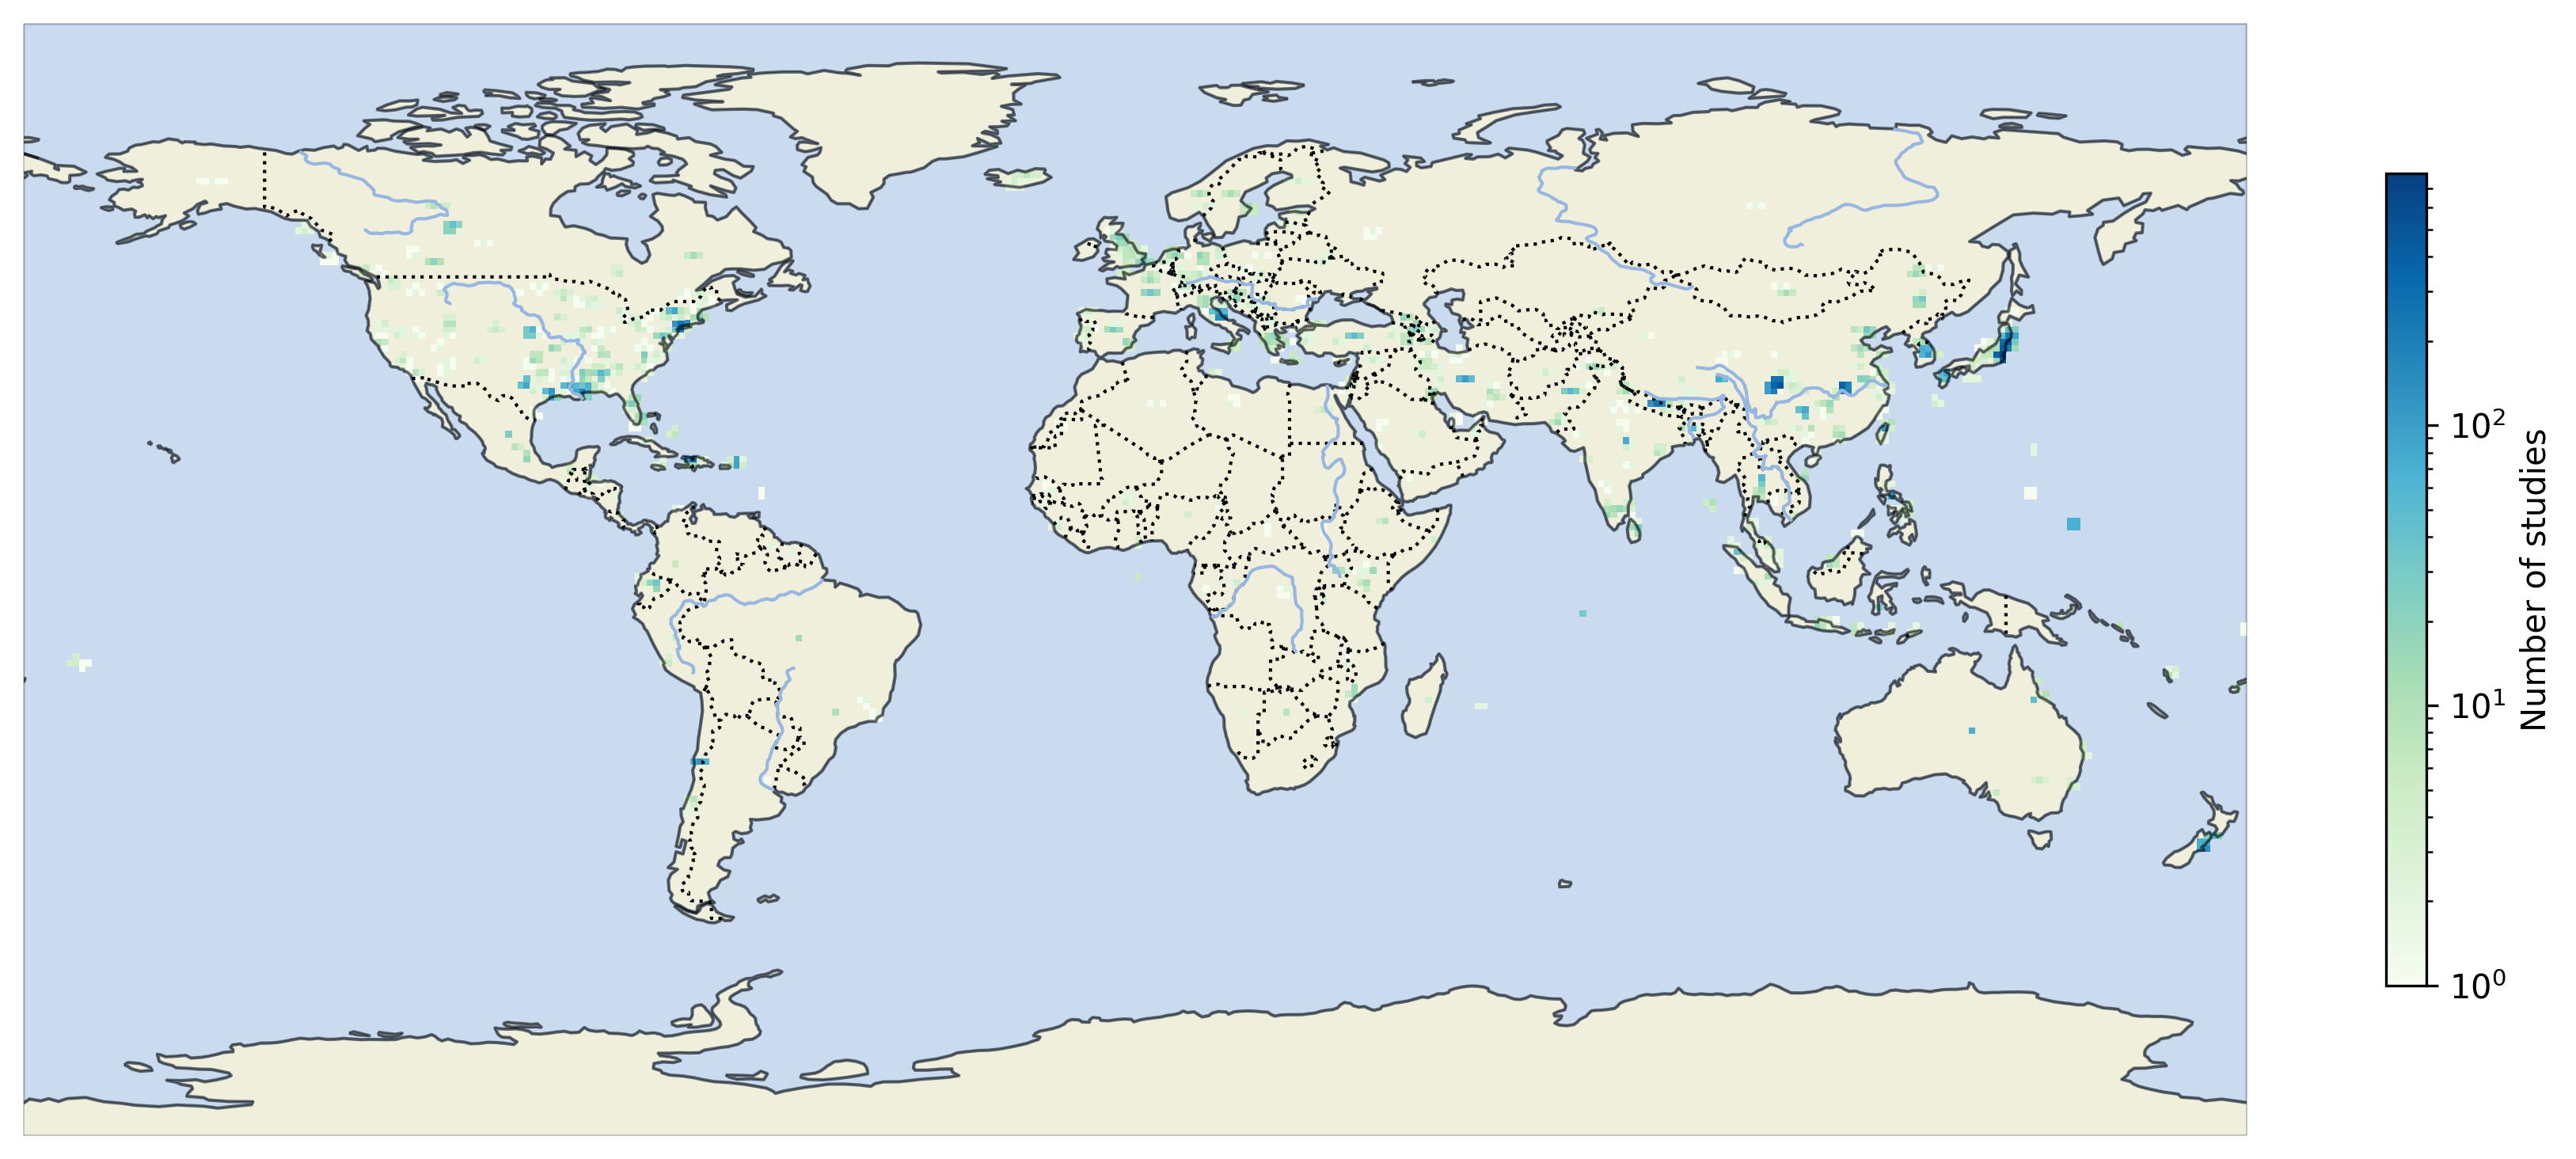

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#fig, ax = plt.subplots(dpi=150, figsize=(12,6))
fig, ax = plt.subplots(dpi=300, figsize=(12,6))

## choose different type of figure 
#p = ccrs.Mollweide()
p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan
###cmap='terrain'
## pcm = plt.scatter(

pcm = plt.pcolormesh(
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha= 1, #0.8,
    #cmap="YlGnBu",
    #cmap="coolwarm",
    #cmap="Reds"
    #cmap="Blues"
    #cmap="Oranges"
    cmap="GnBu",
    
)
# cmap https://wangyeming.github.io/2018/11/07/matplot-cmap/
## scatter plot https://matplotlib.org/3.5.0/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py


ax.outline_patch.set_linewidth(0.1)
cbar = fig.colorbar(pcm, shrink=0.6)
cbar.set_label("Number of studies")

fig.tight_layout()
#plt.show()

folder="/home/linyu.linyu/health/data/cls_output/figure_out/"
#plt.savefig(folder + "/predicted_places_all_density.png",dpi=125)
#plt.savefig(folder + "/predicted_places_all_density2.png",dpi=250,bbox_inches="tight")
#plt.savefig(folder + "/predicted_places_all_density.pdf")

from matplotlib.backends.backend_pdf import PdfPages
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure3_globalmap.pdf"
pp = PdfPages(file_path)
pp.savefig(fig)
pp.close()
plt.show()


### get top topic for each continents

In [14]:
import json 
import pandas as pd 
folder = "/home/linyu.linyu/health/data/cls_output/topic_out/"
topic_scores = json.loads( open( folder + "/topic40_output.json", "r").read() )
topic_names = pd.read_csv( folder + "/topic_models.csv" )
doc2topic = np.array( topic_scores['doc2topic'] )
score_th = 0.015 ## see figure2_6
data.head()

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707,NaN,High income
1,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188,NaN,High income
2,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191,AS,High income
3,NaN,36.00000,138.00000,JPN,1862185,Honshū Island,T,ISL,6,Honshu,JPN,0.895296,AS,High income
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,11,Fukushima,JPN,0.951695,AS,High income


In [19]:
topic_names.head(5)
#topic_names['Aggregated_meta_topic'].value_counts()

,Unnamed: 0,Aggregated_meta_topic,Aggregated_topic,Topic_name,Top_3_stemmed_keywords,Topic_prevalence,Topic_idx,Prevalence_score
0,0,Natural disasters,Natural disaster,Natural disaster,"disaster, natural, review",topic 23,23,1.781540
1,1,Natural disasters,Heat waves,Heat waves,"heat, wave, temperature",topic 2,2,0.781942
2,2,Natural disasters,Earthquake,Nepal and Aquila earthquake,"earthquake, nepal, aquila",topic 10,10,1.665045
3,3,Natural disasters,Nuclear disaster,Fukushima nuclear disaster,"fukushima, evacuation, nuclear",topic 15,15,0.897653
4,4,Natural disasters,Tsunami,Japan tsunami,"tsunami, Japan, east",topic 8,8,1.396157


In [31]:
doc2pick_topic = list()
for i in range(len(doc2topic)):
    related_topics = [ j for j in range(40) if doc2topic[i][j] >= score_th]
    doc2pick_topic.append( related_topics )

doc_topics = list()
for i in range(len(data)):
    doc_idx = data['doc_id'].iloc[i]
    related_topic_idx = doc2pick_topic[doc_idx]
    doc_topics.append( related_topic_idx )
data['doc_topics'] = doc_topics
data.head()

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income,doc_topics
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707,NaN,High income,"[6, 17, 19, 28, 32]"
1,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188,NaN,High income,"[5, 7, 18, 20, 21]"
2,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191,AS,High income,"[0, 8, 9, 15, 22, 30, 35]"
3,NaN,36.00000,138.00000,JPN,1862185,Honshū Island,T,ISL,6,Honshu,JPN,0.895296,AS,High income,"[8, 10, 15, 23]"
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,11,Fukushima,JPN,0.951695,AS,High income,"[3, 8, 15, 16]"


In [32]:
for meta_topic in topic_names['Aggregated_meta_topic'].value_counts().keys():
    topic_ids = topic_names[topic_names['Aggregated_meta_topic'] == meta_topic]['Topic_idx'].to_list()
    topic_ids = set(topic_ids)
    data[meta_topic] = data['doc_topics'].apply( lambda lst: [v for v in lst if v in topic_ids] )
data.head(5)

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income,doc_topics,Health risks & impacts,Coping & responses,Natural disasters
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707,NaN,High income,"[6, 17, 19, 28, 32]",[28],[19],"[6, 17, 32]"
1,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188,NaN,High income,"[5, 7, 18, 20, 21]",[21],"[7, 18]","[5, 20]"
2,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191,AS,High income,"[0, 8, 9, 15, 22, 30, 35]","[0, 22, 30]","[9, 35]","[8, 15]"
3,NaN,36.00000,138.00000,JPN,1862185,Honshū Island,T,ISL,6,Honshu,JPN,0.895296,AS,High income,"[8, 10, 15, 23]",[],[],"[8, 10, 15, 23]"
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,11,Fukushima,JPN,0.951695,AS,High income,"[3, 8, 15, 16]",[16],[3],"[8, 15]"


In [43]:
from collections import defaultdict

continent_map = {
    "nan": "North America",       
    "EU": "Europe", 
    "OC": "Oceania", 
    "AF": "Africa", 
    "SA": "South America",
    "AS": "Asia"
}    

meta_topic_names = sorted(list( topic_names['Aggregated_meta_topic'].value_counts().keys() ))
topic_name_map =  { topic_names['Topic_idx'].iloc[i]: topic_names['Topic_name'].iloc[i] for i in range(40)}

out_data = []
show_cnt = 10
data['continent'] = data['continent'].apply(str)

for cont in continent_map:
    check_data = data[ data['continent'] == cont ]
    
    print("\n\nCont: ", continent_map[cont])
    for meta_topic in meta_topic_names:
        print("\tMetaTopic: ", meta_topic)
        topic_count =  defaultdict(int)     
        topic_idx = sum(check_data[meta_topic].to_list(), [] )
        for t in topic_idx:
            topic_count[t] += 1
        topic_freq_names = [[ topic_count[i], topic_name_map[i]] for i in range(40)]
        topic_freq_names.sort(reverse=True)
        
        show_out = [] 
        for t_freq, t_name in topic_freq_names[:show_cnt]:
            show_out.append( "[%s %d]"%(t_name,t_freq))
        print("\t\t" + "".join(show_out))
        print()
   



Cont:  South America
	MetaTopic:  Coping & responses
		[Posttraumatic growth  20][Parent-child 20][Mental health services 19][Posttraumatic growth  18][Survivor 12][Adolescent 12][Religious coping 11][Social support 9][Group 9][Visits to healthcare facilities 7]

	MetaTopic:  Health risks & impacts
		[PTSD 39][PTSD 31][Cholera & leptospirosis 26][Depression 19][Infectious diseases 16][Birth & pregnancy 13][Mortality 12][Quality of life 10][Psychological distress 10][Anxiety 7]

	MetaTopic:  Natural disasters
		[Nepal and Aquila earthquake 55][Natural disaster 31][Extreme weather 23][Japan tsunami 14][Flood 9][Heat waves 6][Hurricane Katrina 4][Hurricane Maria 3][Fukushima nuclear disaster 1][Worker 0]



Cont:  North America
	MetaTopic:  Coping & responses
		[Mental health services 401][Visits to healthcare facilities 238][Hospital & patients 191][Survivor 146][Parent-child 145][Group 144][Social support 140][Resilience 105][Posttraumatic growth  105][Worker 81]

	MetaTopic:  Health 

In [42]:
data['continent'].value_counts()

AS     2569
nan    1188
EU      399
OC      272
SA      111
AF       79
Name: continent, dtype: int64

In [30]:
data.head()

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income,doc_topics
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707,NaN,High income,"[6, 17, 19, 28, 32]"
1,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188,NaN,High income,"[5, 7, 18, 20, 21]"
2,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191,AS,High income,"[0, 8, 9, 15, 22, 30, 35]"
3,NaN,36.00000,138.00000,JPN,1862185,Honshū Island,T,ISL,6,Honshu,JPN,0.895296,AS,High income,"[8, 10, 15, 23]"
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,11,Fukushima,JPN,0.951695,AS,High income,"[3, 8, 15, 16]"
